In [1]:
from os import path

# Third-party
from astropy.io import fits
from astropy.table import Table, join
import astropy.coordinates as coord
from astropy.stats import mad_std
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from schwimmbad import MultiPool

from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves

from twoface.sample_prior import make_prior_cache

/home/adrianp/.conda/envs/twoface/lib/python3.6/site-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/adrianp/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


In [2]:
# DR13_PATH = '/Users/adrian/Data/APOGEE_DR13/'
# DR14_PATH = '/Users/adrian/Data/APOGEE_DR14/'
DR13_PATH = '../data/dr13/'
DR14_PATH = '../data/dr14/'

In [3]:
with MultiPool() as pool:
    print(pool.size)

28


In [4]:
star_columns = ['APOGEE_ID', 'NVISITS', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR']
visit_columns = ['VISIT_ID', 'APOGEE_ID', 'MJD', 'JD', 'VREL', 'VRELERR', 'VHELIO', 'SNR', 'CHISQ']

In [5]:
def read_table(filename, columns):
    tbl = fits.getdata(filename)
    return Table(tbl.view(tbl.dtype, np.ndarray)[columns])

In [6]:
allstar_dr13 = read_table(path.join(DR13_PATH, 'allStar-l30e.2.fits'), star_columns)
allvisit_dr13 = read_table(path.join(DR13_PATH, 'allVisit-l30e.2.fits'), visit_columns)

allstar_dr14 = read_table(path.join(DR14_PATH, 'allStar-l31c.2.fits'), star_columns)
allvisit_dr14 = read_table(path.join(DR14_PATH, 'allVisit-l31c.2.fits'), visit_columns)

In [7]:
_, uniq_idx = np.unique(allstar_dr13['APOGEE_ID'], return_index=True)
dr13 = join(allvisit_dr13, allstar_dr13[uniq_idx], join_type='left',
            keys='APOGEE_ID')

_, uniq_idx = np.unique(allstar_dr14['APOGEE_ID'], return_index=True)
dr14 = join(allvisit_dr14, allstar_dr14[uniq_idx], join_type='left',
            keys='APOGEE_ID')

In [8]:
both = join(dr13, dr14, 
            join_type="inner", keys=['APOGEE_ID', 'JD'],
            table_names=['dr13', 'dr14'])
print(len(both))

509884


In [9]:
assert np.all(both['MJD_dr13'] == both['MJD_dr14'])

## Restrict to red giants and good visits

In [10]:
mask = ((both['LOGG_dr14'] < 3) & (both['LOGG_dr14'] > -999) & 
        np.isfinite(both['VHELIO_dr13']) & np.isfinite(both['VHELIO_dr14']))
mask.sum()

262837

In [11]:
df = both[mask].to_pandas()
grouped = df.groupby('APOGEE_ID')

In [12]:
np.random.seed(42)
nper_bin = 8

apogee_ids = dict()
for nvisits in [4, 8, 16]:
    visits = grouped.filter(lambda x: len(x) == nvisits)
    apogee_ids[nvisits] = np.random.choice(np.array(visits['APOGEE_ID']).astype(str), 
                                           replace=False, size=nper_bin)

Set up _The Joker_:

/home/adrianp/.conda/envs/twoface/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


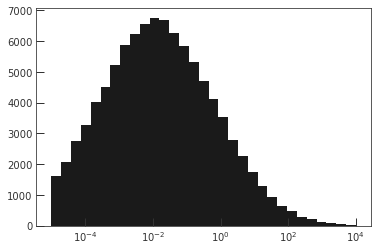

In [13]:
logs2 = np.random.normal(5, 8, size=100000)
s = np.sqrt(np.exp(logs2))
plt.hist(s/1000., bins=np.logspace(-5, 4, 32)); # km/s
plt.xscale('log')

In [14]:
prior_file = 'dr14_dr13_prior_samples.h5'
params = JokerParams(P_min=8*u.day, P_max=32768*u.day,
                     jitter=(5., 8.), jitter_unit=u.m/u.s)

In [15]:
if not path.exists(prior_file):
    joker = TheJoker(params)
    make_prior_cache(prior_file, joker,
                     N=2**29, max_batch_size=2**24)

/home/adrianp/.conda/envs/twoface/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


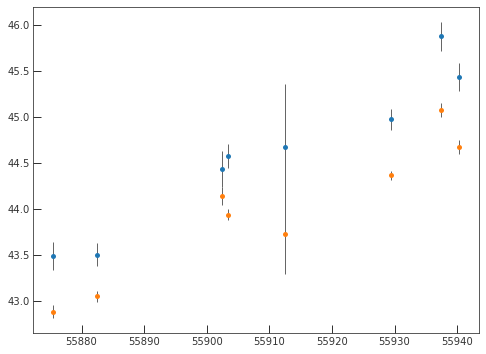

In [34]:
ap_id = apogee_ids[8][6]

rows = both[both['APOGEE_ID'] == ap_id]

data_dr13 = RVData(t=Time(rows['JD'], format='jd', scale='utc'), 
                   rv=np.array(rows['VHELIO_dr13']).astype('<f8') * u.km/u.s,
                   stddev=np.array(rows['VRELERR_dr13']).astype('<f8') * u.km/u.s)

data_dr14 = RVData(t=Time(rows['JD'], format='jd', scale='utc'), 
                   rv=np.array(rows['VHELIO_dr14']).astype('<f8') * u.km/u.s,
                   stddev=np.array(rows['VRELERR_dr14']).astype('<f8') * u.km/u.s)

fig,ax = plt.subplots(1, 1, figsize=(8,6))
data_dr13.plot(ax=ax, color='tab:blue')
data_dr14.plot(ax=ax, color='tab:orange')

In [35]:
n_samples = 128
with MultiPool() as pool:
    joker = TheJoker(params, pool=pool)

    samples_dr13 = joker.iterative_rejection_sample(data_dr13, 
                                                    n_requested_samples=n_samples, 
                                                    prior_cache_file=prior_file) 

    samples_dr14 = joker.iterative_rejection_sample(data_dr14, 
                                                    n_requested_samples=n_samples, 
                                                    prior_cache_file=prior_file) 

samples_dr13 = samples_dr13[:n_samples]
samples_dr14 = samples_dr14[:n_samples]
print(len(samples_dr13), len(samples_dr14))

NameError: name 'sampes_dr13' is not defined

/home/adrianp/.conda/envs/twoface/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


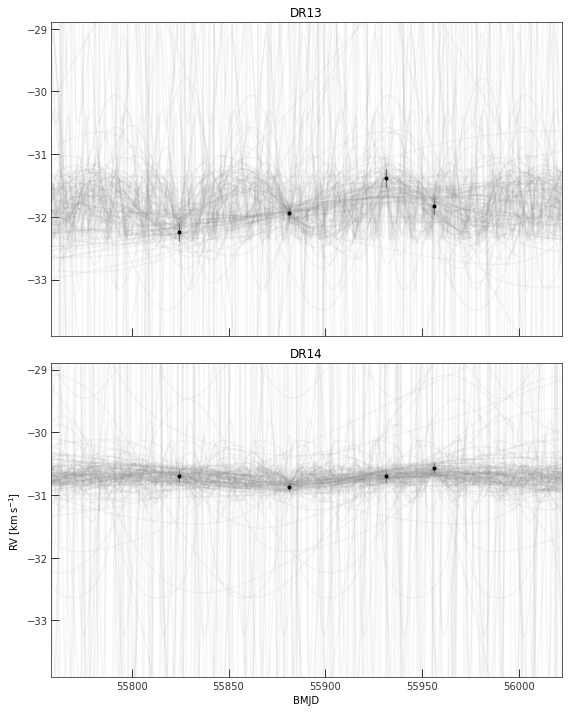

In [25]:
span = np.ptp(data_dr13.t.mjd)
t_grid = np.linspace(data_dr13.t.mjd.min()-0.5*span, 
                     data_dr13.t.mjd.max()+0.5*span, 
                     1024)

fig, axes = plt.subplots(2, 1, figsize=(8,10), sharex=True, sharey=True)
axes[0].set_xlim(t_grid.min(), t_grid.max())

_ = plot_rv_curves(samples_dr13, t_grid, rv_unit=u.km/u.s, data=data_dr13, 
                   ax=axes[0], plot_kwargs=dict(color='#888888'), n_plot=128,
                   add_labels=False)

_ = plot_rv_curves(samples_dr14, t_grid, rv_unit=u.km/u.s, data=data_dr14, 
                   n_plot=128, ax=axes[1], plot_kwargs=dict(color='#888888'))

rv_min = min(data_dr13.rv.to(u.km/u.s).value.min(),
             data_dr14.rv.to(u.km/u.s).value.min())
rv_max = max(data_dr13.rv.to(u.km/u.s).value.max(),
             data_dr14.rv.to(u.km/u.s).value.max())
yspan = rv_max-rv_min

axes[0].set_ylim(rv_min-yspan, rv_max+yspan)

axes[0].set_title('DR13')
axes[1].set_title('DR14')

fig.set_facecolor('w')
fig.tight_layout()

/home/adrianp/.conda/envs/twoface/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


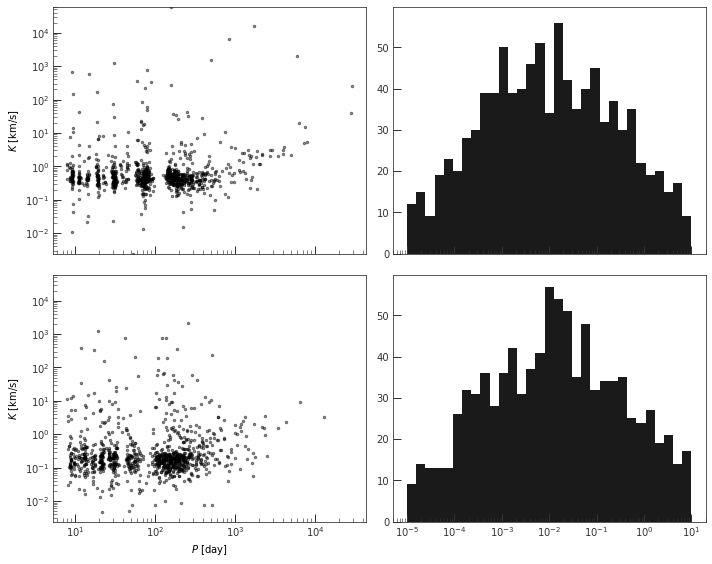

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), 
                         sharex='col', sharey='col')

axes[0,0].scatter(samples_dr13['P'].value, 
                  samples_dr13['K'].to(u.km/u.s).value,
                  marker='.', color='k', alpha=0.45)

axes[1,0].scatter(samples_dr14['P'].value, 
                  samples_dr14['K'].to(u.km/u.s).value,
                  marker='.', color='k', alpha=0.45)

axes[1,0].set_xlabel("$P$ [day]")
axes[0,0].set_ylabel("$K$ [km/s]")
axes[1,0].set_ylabel("$K$ [km/s]")
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(samples_dr13['K'].to(u.km/u.s).value.min(), 
                   samples_dr13['K'].to(u.km/u.s).value.max())

# jitter

bins = np.logspace(-5, 1, 32)
axes[0,1].hist(samples_dr13['jitter'].to(u.km/u.s).value, bins=bins)
axes[1,1].hist(samples_dr14['jitter'].to(u.km/u.s).value, bins=bins)
axes[0,1].set_xscale('log')

fig.tight_layout()